# Aula 20 - Assícrona - Atividade Prática 03

##  Implementação de modelos e verificação de eficiência da estratégia adotada em problemas de classificação considerando diferentes métodos de engenharia de features

### Grupo 15

### Nome: Ubiratan da Silva Tavares - RA: 23031559

#### Práticas a serem desenvolvidas:

1 - Substituição de valores inválidos;

2 - Verificação de eficiência considerando técnicas de normalização;

3 - Seleção de *Features*;

4 - Extração de *Features*;

5 - Validação Cruzada considerando o método *k-fold*.

### Parâmetros fixos a serem utilizados:

1 - Classificador ***Random Forest*** com `random_state = 0`;

2 - Função `train_test_split`:

     - Proporção de divisão de dados de treinamento e teste: 70% e 30%, respectivamente;
     - `random_state = 42`.
     


In [1]:
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class DataSet:
    
    def __init__(self, nome_arquivo):
        self.__dataframe = read_csv(nome_arquivo, delimiter=',', header=0)

    @property
    def dataframe(self):
        return self.__dataframe
    
    def getXy(self):
        X = self.dataframe.iloc[:, :-1]
        y = self.dataframe.iloc[:, -1]        
        return X, y    
    
    # verificando a existência de valores inválidos
    def verificar_valores_invalidos(self):
        return self.dataframe.isnull().sum() / len(self.dataframe) * 100    
  
    # transformando a base de dados após a verificação 
    # da existência de valores inválidos
    def transformar(self):
        percentual_invalidos = self.verificar_valores_invalidos()
        # iterando sobre cada coluna da base de dados
        for coluna in self.dataframe.columns:
            if percentual_invalidos[coluna] > 20:
                # excluindo a coluna se a porcentagem de valores 
                # inválidos for maior que 20%
                self.dataframe.drop(coluna, axis=1, inplace=True)
            elif percentual_invalidos[coluna] > 0:
                # substituindo os valores inválidos pelo 
                # valor imediatamente anterior utilizando o método bfill
                self.dataframe[coluna].fillna(method='bfill', inplace=True)
                
    # normalizando os atributos previsores (atributos de entrada)
    def normalizar(self, X):
        # criando uma instância do MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1))        
        # ajustando e transformando com o scaler 
        # os dados dos atributos previsores
        X_norm = scaler.fit_transform(X)
        return scaler, X_norm
    
    # desnormalizando os atributos previsores (atributos de entrada)
    def desnormalizar(self, scaler, X_norm):
        X = scaler.inverse_transform(X_norm)
        colunas = len(X_norm[-1, :])
        X = X.reshape(-1, colunas)
        return X        
        
    def get_train_test_split(self, test_size=0.3, random_state=42):
        X, y = self.getXy()
        _, X_norm = self.normalizar(X)
        X_train, X_test, y_train, y_test = train_test_split(X_norm, 
                                                            y, 
                                                            test_size=test_size, 
                                                            random_state=random_state)
        return X_train, X_test, y_train, y_test

In [2]:
# Criando a classe abstrata para ser herdado 
# pelos modelos k-Nearest Neighbor e Random Forest

from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport

import numpy as np

class Modelo(ABC):    
   
    @abstractmethod
    def criar(self, parametro):
        pass
    
    # treinando o classificador com os dados de treinamento
    def treinar(self, modelo, X_train, y_train):
        modelo_fit = modelo.fit(X_train, y_train)
        return modelo_fit
    
    # aplicando o método de seleção de recursos 
    # com RFE, considerando n recursos
    def aplicar_rfe(self, modelo, X_train, y_train, n_recursos=3):
        rfe = RFE(estimator=modelo, n_features_to_select=n_recursos, step=1)
        X_rfe = rfe.fit_transform(X_train, y_train)
        return rfe, X_rfe
    
    # identificando os recursos 
    # selecionados com o método RFE
    def identificar_recursos_rfe(self, rfe):
        return np.where(rfe.support_)[0]
    
    def exibir_informacoes_rfe(self, rfe):
        recursos = np.where(rfe.support_)[0]
        print(f"Ranking dos atributos: {rfe.ranking_}")
        print(f"\nSuporte dos atributos selecionados: {rfe.support_}")
        print(f"\nAtributos selecionados: {self.identificar_recursos_rfe(rfe)}\n")        

    # aplicando o método de extração de 
    # recursos com PCA, considerando n componentes
    def aplicar_pca(self, X_train, X_test, n_components=3):
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        return pca, X_train_pca, X_test_pca
    
    # exibindo as informações relevantes do modelo PCA
    def exibir_informacoes_pca(self, pca):
        print(f"Variância explicada por cada componente principal: {pca.explained_variance_ratio_}\n")
        print(f"\nVariância explicada acumulada: {np.cumsum(pca.explained_variance_ratio_)}\n")
    
    # realizando as previsões com os dados de teste
    def prever(self, modelo_treinado, X_test):
        return modelo_treinado.predict(X_test)
    
    # avaliando o desempenho do modelo
    def avaliar(self, y_test, y_pred, classes):
        return classification_report(y_test, y_pred, target_names=classes)
    
    # imprimindo o resultado da avaliação do desempenho do modelo
    def imprimir_avaliacao(self, avaliacao):
        print(avaliacao)
        
    # plotando o resultado da avaliação do desempenho 
    # do modelo com a classe ClassificationReport da biblioteca yellowbrick
    def plotar_avaliacao(self, modelo, X_train, X_test, y_train, y_test):        
        cr = ClassificationReport(modelo, classes=[0, 1], support=True)
        cr.fit(X_train, y_train)
        cr.score(X_test, y_test)
        cr.poof()
        
    # plotando o resultado da acurácia do modelo 
    # de acordo com o número de árvores na floresta.
    def plotar_numero_arvores(self, grid_search):
        resultados = grid_search.cv_results_
        scores = resultados['mean_test_score']
        num_arvores = resultados['param_n_estimators'].data
        plt.figure(figsize=(10, 6))
        plt.plot(num_arvores, scores, marker='o', linestyle='-')
        plt.title('Acurácia em função do número de árvores na Floresta Aleatória')
        plt.xlabel('Número de Árvores na Floresta')
        plt.ylabel('Acurácia Média (Validação Cruzada)')
        plt.grid(True)
        plt.show()
        
    # buscando o numero de arvores com a validação cruzada
    def buscar_melhor_numero_arvores(self, X_train, y_train, num_arvores_range=range(10, 101, 10), cv=10):
        melhor_score = 0
        melhor_numero_arvores = None
        media_scores = []
        for n_arvore in num_arvores_range:
            model = self.criar(n_arvore)
            kfold = KFold(n_splits=cv, shuffle=True, random_state=0)
            scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
            media_score = scores.mean()
            media_scores.append(media_score)
            if media_score > melhor_score:
                melhor_score = media_score
                melhor_numero_arvores = n_arvore
        return media_scores, melhor_numero_arvores
    
    # plotando a acurácia versus o numero de arvores
    def plot_resultados_avaliacao_cruzada(self, scores, num_arvores_range=range(10, 101, 10)):
        plt.figure(figsize=(8, 6))
        plt.plot(num_arvores_range, scores, marker='o', linestyle='-')
        plt.title("Validação Cruzada para Random Forest")
        plt.xlabel("Número de Árvores na Floresta")
        plt.ylabel("Acurácia Média")
        plt.grid(True)
        plt.show()

In [3]:
# Criando a classe para o modelo Random Forest

from sklearn.ensemble import RandomForestClassifier

class RandomForest(Modelo):
    
    # criando o modelo do classificador 
    # Ranfom Forest com 10 árvores como default
    def criar(self, parametro):
        return RandomForestClassifier(n_estimators=parametro, random_state=0) 


**Questão 1)** Considere o banco de dados `water_potability.csv`.

In [4]:
# criando um objeto da classe DataSet 
data = DataSet("water_potability.csv")

# realizando a leitura da base de dados com o objeto data
df = data.dataframe

# visualizando as 5 primeiras instâncias 
# dos atributos da base de dados
print(df.head())

# verificando a quantidade de 
# linhas e colunas da base de dados
print(df.shape)

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
(3276, 10)


**a)** Verifique a existência de valores inválidos nos dados de entrada do *dataset* e, caso existam, observe os seguintes pontos:

    - Se a porcentagem de dados inválidos for maior do que 20%, exclua esta(s) coluna(s);
    - Se a porcentagem de dados inválidos for inferior a 20%, substitua os valores inválidos pelo valor imediatamente anterior, o método `bfill`.

In [5]:
# verificando a existência de valores inválidos na base de dados
percentual_invalidos = data.verificar_valores_invalidos()

# exibindo o percentual de valores inválidos na base de dados
print(percentual_invalidos)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64


In [6]:
# transformando a base de dados após a verificação 
# da existência de valores inválidos
data.transformar()

# realizando a leitura da base de dados com o objeto data
df = data.dataframe

# visualizando as 5 primeiras instâncias dos atributos da base de dados
print(df.head())

# verificando a quantidade de instâncias e atributos da base de dados
print(df.shape)

         ph    Hardness        Solids  Chloramines  Conductivity  \
0  3.716080  204.890455  20791.318981     7.300212    564.308654   
1  3.716080  129.422921  18630.057858     6.635246    592.885359   
2  8.099124  224.236259  19909.541732     9.275884    418.606213   
3  8.316766  214.373394  22018.417441     8.059332    363.266516   
4  9.092223  181.101509  17978.986339     6.546600    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
(3276, 9)


In [7]:
# verificando a existência de valores inválidos na base de dados
percentual_invalidos = data.verificar_valores_invalidos()

# exibindo o percentual de valores inválidos na base de dados
print(percentual_invalidos)

# verificando a quantidade de cada classe do atributo alvo
classes = df['Potability'].value_counts()
print(classes)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64
0    1998
1    1278
Name: Potability, dtype: int64


**b)** Normalize os dados de entrada através do método `MinMaxScaler`.

In [8]:
# criando os atributos previsores e o atributo alvo
X, y = data.getXy()

print(X.shape, y.shape)

(3276, 8) (3276,)


In [9]:
print(X.iloc[0:5, :])

         ph    Hardness        Solids  Chloramines  Conductivity  \
0  3.716080  204.890455  20791.318981     7.300212    564.308654   
1  3.716080  129.422921  18630.057858     6.635246    592.885359   
2  8.099124  224.236259  19909.541732     9.275884    418.606213   
3  8.316766  214.373394  22018.417441     8.059332    363.266516   
4  9.092223  181.101509  17978.986339     6.546600    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  
0       10.379783        86.990970   2.963135  
1       15.180013        56.329076   4.500656  
2       16.868637        66.420093   3.055934  
3       18.436524       100.341674   4.628771  
4       11.558279        31.997993   4.075075  


In [10]:
# criando o objeto scaler e os atributos previsores normalizado
scaler, X_norm = data.normalizar(X)

# visualizando as 5 primeiras linhas
print(X_norm[0:5, :])

[[0.26543429 0.57113901 0.33609646 0.54389134 0.66943948 0.31340165
  0.69975313 0.28609102]
 [0.26543429 0.29740043 0.30061142 0.49183921 0.71941108 0.49731851
  0.4509993  0.57679264]
 [0.57850887 0.64131081 0.32161885 0.69854275 0.41465206 0.56201674
  0.5328657  0.30363656]
 [0.59405471 0.60553587 0.35624379 0.60331369 0.31788047 0.62208906
  0.80806473 0.60101542]
 [0.64944453 0.48485088 0.28992169 0.48490019 0.37933671 0.35855477
  0.25360608 0.49632736]]


**c)** Realize a tarefa de classificação utilizando ***Random Forest***, considerando 10 árvores na floresta.

In [11]:
# dividindo a base de dados em dados de treinamento e teste
X_train, X_test, y_train, y_test = data.get_train_test_split()

# verificando a quantidade de cada classe do atributo alvo
print(y_train.value_counts())
print(f'{(y_train.value_counts()[0]/y_train.shape[0]) * 100:.1f}')
print(f'{(y_train.value_counts()[1]/y_train.shape[0]) * 100:.1f}')

print(y_test.value_counts())
print(f'{(y_test.value_counts()[0]/y_test.shape[0]) * 100:.1f}')
print(f'{(y_test.value_counts()[1]/y_test.shape[0]) * 100:.1f}')

# verificando as dimensões dos arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# criando uma instância da classe RandomForest
rf = RandomForest()

# criando o modelo Random Forest
modelo_rf = rf.criar(10)

# treinando o modelo com os dados de treinamento
modelo_rf_treinado = rf.treinar(modelo_rf, X_train, y_train)

# utilizando o modelo treinado para prever o 
# atributo alvo a partir dos dados de teste
y_pred = rf.prever(modelo_rf_treinado, X_test)

0    1381
1     912
Name: Potability, dtype: int64
60.2
39.8
0    617
1    366
Name: Potability, dtype: int64
62.8
37.2
(2293, 8) (983, 8) (2293,) (983,)


**d)** Verifique a eficiência do método empregado utilizando a função `classification_report`.

              precision    recall  f1-score   support

           0       0.66      0.81      0.72       617
           1       0.47      0.29      0.36       366

    accuracy                           0.61       983
   macro avg       0.56      0.55      0.54       983
weighted avg       0.59      0.61      0.59       983



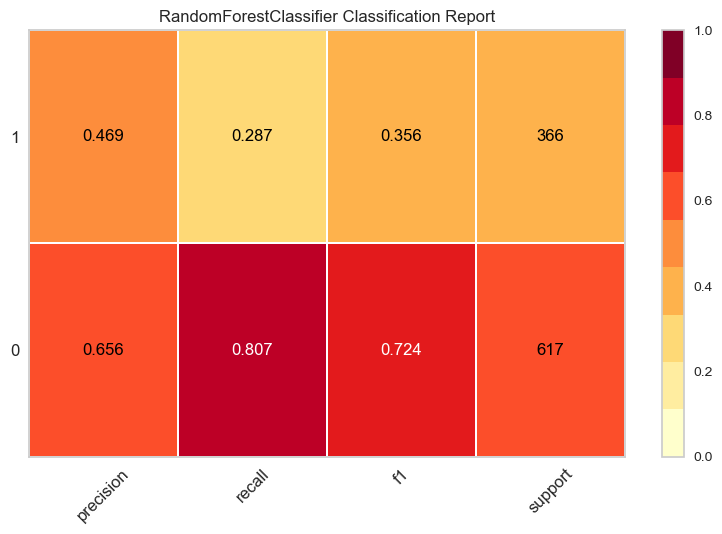

In [12]:
# avaliando a performance do modelo classificador a 
# partir dos dados de teste e o resultado das previsões
avaliacao_classificador = rf.avaliar(y_test, y_pred, ['0', '1'])

# exibindo avaliação do classificador
rf.imprimir_avaliacao(avaliacao_classificador)

# plotando a avaliação do classificador
rf.plotar_avaliacao(modelo_rf, X_train, X_test, y_train, y_test)

**Questão 2)** Considerando os dados normalizados e o modelo do classificador criado no exercício anterior, utilize o método de **seleção de features** **RFE** (*Recursive Feature Elimination*) para selecionar **3** *features* que farão parte da tarefa de classificação. Identifique quais colunas foram selecionadas. Analise os resultados por meio da função `classification_report`.

(2293, 3)
Ranking dos atributos: [1 1 1 3 6 2 5 4]

Suporte dos atributos selecionados: [ True  True  True False False False False False]

Atributos selecionados: [0 1 2]

(983, 3)
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       617
           1       0.48      0.28      0.35       366

    accuracy                           0.62       983
   macro avg       0.57      0.55      0.54       983
weighted avg       0.59      0.62      0.59       983



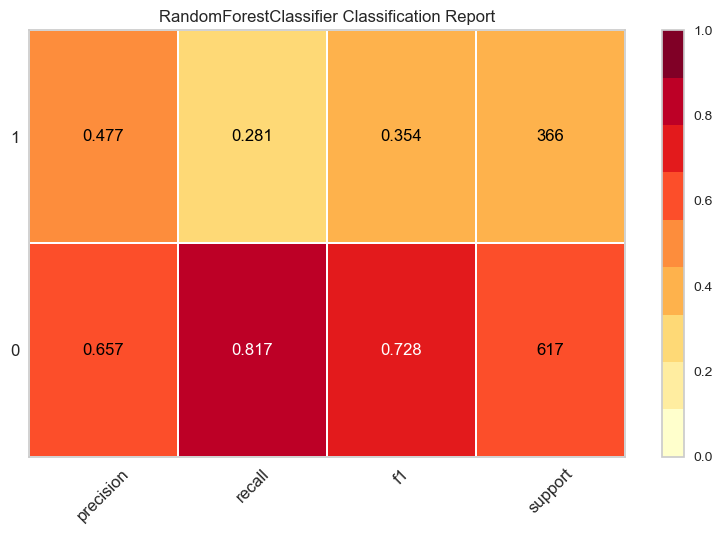

In [13]:
# selecionando os atributos com o método RFE
rfe, X_train_rfe = rf.aplicar_rfe(modelo_rf, X_train, y_train)

# verificando a quantidade de linhas e colunas após 
# aplicar do método de seleção de features RFE
print(X_train_rfe.shape)

# exibindo os atributos selecionados com o método RFE
rf.exibir_informacoes_rfe(rfe)

# treinando o modelo após aplicar do método de seleção de features RFE
modelo_rf_treinado_rfe = rf.treinar(modelo_rf, X_train_rfe, y_train)

# identificando os atributos selecionados com o método RFE
atributos_selecionados = rf.identificar_recursos_rfe(rfe)

# selecionando os atributos selecionados na base de dados de teste
X_test_rfe = X_test[:, atributos_selecionados]

# verificando a quantidade de linhas e colunas
print(X_test_rfe.shape)

# realizando previsões com os dados de teste após aplicar o RFE
y_pred_rfe = rf.prever(modelo_rf_treinado_rfe, X_test_rfe)

# avaliando o desempenho do modelo após aplicar o RFE
avaliacao_classificador_rfe = rf.avaliar(y_test, y_pred_rfe, ['0', '1'])
rf.imprimir_avaliacao(avaliacao_classificador_rfe)
rf.plotar_avaliacao(modelo_rf, X_train_rfe, X_test_rfe, y_train, y_test)

**Questão 3)** Considerando os dados normalizados e o modelo do classificador criado na **Questão 1)**, utilize a **Análise de Componentes Principais** para extrair as *features* que farão parte da tarefa de classificação. Considere utilizar **3** componentes principais e analise os resultados por meio da função `classification_report`.

(2293, 3)
Variância explicada por cada componente principal: [0.16312044 0.14989963 0.14660769]


Variância explicada acumulada: [0.16312044 0.31302007 0.45962776]

              precision    recall  f1-score   support

           0       0.63      0.75      0.69       617
           1       0.38      0.26      0.31       366

    accuracy                           0.57       983
   macro avg       0.51      0.51      0.50       983
weighted avg       0.54      0.57      0.55       983



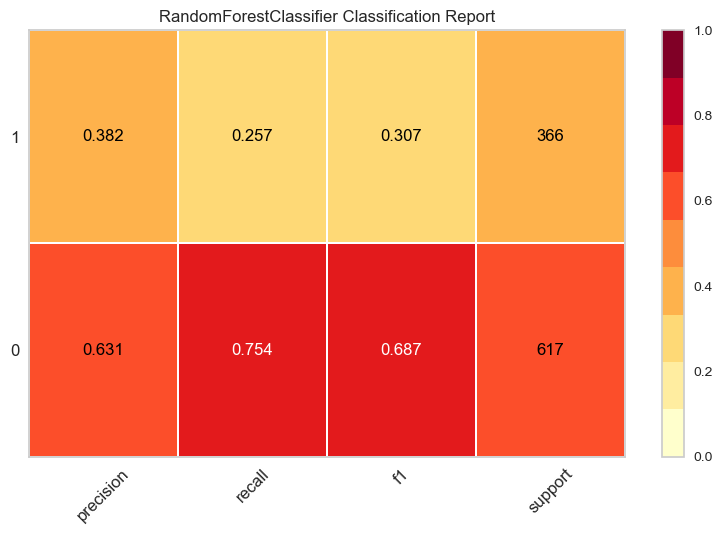

In [14]:
# aplicando PCA com 3 componentes principais
pca, X_train_pca, X_test_pca = rf.aplicar_pca(X_train, X_test)

# verificando a quantidade de linhas e colunas após aplicar do método PCA
print(X_train_rfe.shape)

#  visualizando as informações relevantes do modelo PCA
rf.exibir_informacoes_pca(pca)

# treinando o modelo Random Forest com os dados de treinamento após o PCA
modelo_rf_treinado_pca = rf.treinar(modelo_rf, X_train_pca, y_train)

# realizando previsões com os dados de teste após o PCA
y_pred_pca = rf.prever(modelo_rf_treinado_pca, X_test_pca)

# avaliando o desempenho do modelo após o PCA
avaliacao_classificador_pca = rf.avaliar(y_test, y_pred_pca, ['0', '1'])
rf.imprimir_avaliacao(avaliacao_classificador_pca)
rf.plotar_avaliacao(modelo_rf, X_train_pca, X_test_pca, y_train, y_test)

**Questão 4)** Considerando as componentes principais extraídas na **Questão 3)**, utilize o método de **Validação Cruzada** por ***k-fold*** para verificar o número de àrvores adequado para a floresta na solução do problema. Considere variar o número de árvores entre 10 e 100, com passo de 10. Considere também `k = 10`, no método *k-fold*. Plote o resultado da acurácia do modelo de acordo com o número de árvores na floresta e realize a classificação considerando o melhor resultado alcançado na etapa de validação.

Variância explicada por cada componente principal: [0.16312044 0.14989963 0.14660769]


Variância explicada acumulada: [0.16312044 0.31302007 0.45962776]

Melhor número de árvores encontrado: 90


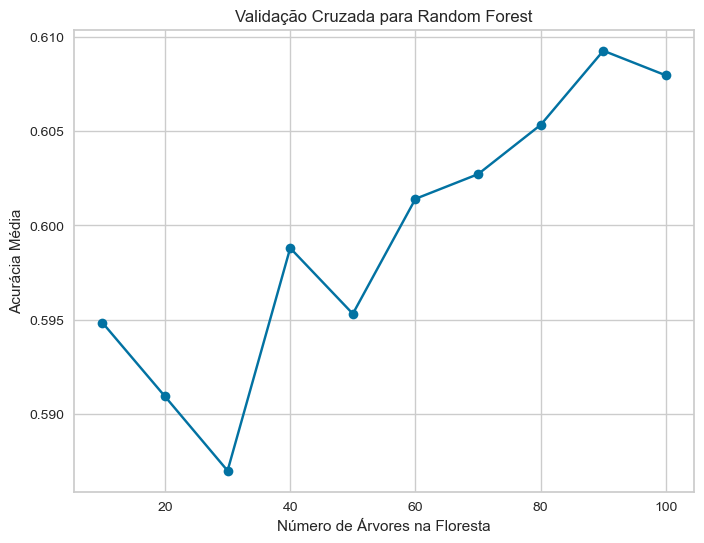

In [15]:
# aplicando PCA com 3 componentes principais
pca, X_train_pca, X_test_pca = rf.aplicar_pca(X_train, X_test)

#  visualizando as informações relevantes do modelo PCA
rf.exibir_informacoes_pca(pca)

# buscando o melhor número de árvores por meio da validação cruzada
media_scores, melhor_n_arvores = rf.buscar_melhor_numero_arvores(X_train, y_train)
print(f"Melhor número de árvores encontrado: {melhor_n_arvores}")

rf.plot_resultados_avaliacao_cruzada(media_scores)

Variância explicada por cada componente principal: [0.16312044 0.14989963 0.14660769]


Variância explicada acumulada: [0.16312044 0.31302007 0.45962776]

              precision    recall  f1-score   support

           0       0.63      0.75      0.68       617
           1       0.37      0.25      0.30       366

    accuracy                           0.56       983
   macro avg       0.50      0.50      0.49       983
weighted avg       0.53      0.56      0.54       983



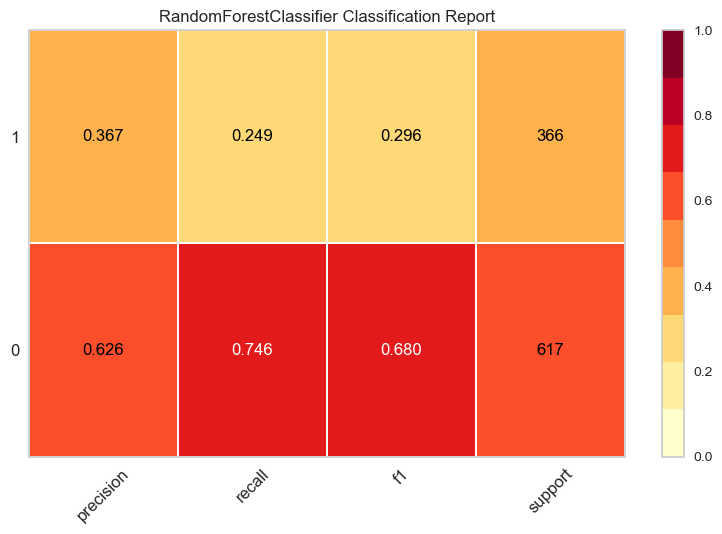

In [16]:
# criando uma instância da classe RandomForest
rf = RandomForest()

# criando o modelo Random Forest
modelo_rf = rf.criar(melhor_n_arvores)

# aplicando PCA com 3 componentes principais
pca, X_train_pca, X_test_pca = rf.aplicar_pca(X_train, X_test)

#  visualizando as informações relevantes do modelo PCA
rf.exibir_informacoes_pca(pca)

# treinando o modelo Random Forest com os dados de treinamento após o PCA
modelo_rf_treinado_pca = rf.treinar(modelo_rf, X_train_pca, y_train)

# realizando previsões com os dados de teste após o PCA
y_pred_pca = rf.prever(modelo_rf_treinado_pca, X_test_pca)

# avaliando o desempenho do modelo após o PCA
avaliacao_classificador_pca = rf.avaliar(y_test, y_pred_pca, ['0', '1'])
rf.imprimir_avaliacao(avaliacao_classificador_pca)
rf.plotar_avaliacao(modelo_rf, X_train_pca, X_test_pca, y_train, y_test)

**Questão 5)** Explique os resultados obtidos nos exercícios anteriores.

Os resultados da função `classification_report` fornecem uma análise detalhada do desempenho do modelo de classificação em relação a várias métricas, incluindo precisão (precision), recall, F1-score e suporte (support) para cada classe. Abaixo são analisados os resultados das questões anteriores.

**Questão 1: Modelo com 8 atributos previsores e 10 árvores na floresta**

```
precision    recall  f1-score   support

           0       0.66      0.81      0.72       617
           1       0.47      0.29      0.36       366

    accuracy                           0.61       983
   macro avg       0.56      0.55      0.54       983
weighted avg       0.59      0.61      0.59       983
```

Neste modelo classificador, com 10 árvores na floresta e utilizando 8 atributos previsores, observa-se o seguinte:

- A precisão (precision) para a classe '0' é de 0,66, o que significa que 66% das predições positivas para a classe '0' estavam corretas. Para a classe '1', a precisão é de 0,47.

- O recall para a classe '0' é de 0,81, indicando que o modelo captura 81% das instâncias da classe '0', enquanto para a classe '1', o recall é de 0,29, sugerindo que o modelo perde muitas instâncias da classe '1'.

- O F1-score para a classe '0' é de 0,72, uma métrica que combina precisão e recall, enquanto para a classe '1', o F1-score é de 0,36, mais baixo devido ao baixo recall.

- A acurácia (accuracy) geral é de 0,61, o que é a proporção total de previsões corretas.

**Questão 2: Modelo com 3 atributos previsores selecionados usando RFE e 10 árvores na floresta**

```
precision    recall  f1-score   support

           0       0.66      0.82      0.73       617
           1       0.48      0.28      0.35       366

    accuracy                           0.62       983
   macro avg       0.57      0.55      0.54       983
weighted avg       0.59      0.62      0.59       983
```

Neste modelo classificador, foram selecionados apenas 3 atributos usando Recursive Feature Elimination (RFE). O desempenho é ligeiramente melhor do que o modelo anterior:

- A precisão para a classe '0' melhorou para 0,66, enquanto a precisão para a classe '1' permaneceu em 0,48.

- O recall para a classe '0' melhorou para 0,82, mas o recall para a classe '1' ainda é baixo em 0,28.

- O F1-score para a classe '0' também melhorou para 0,73, enquanto para a classe '1' ainda é relativamente baixo em 0,35.

- A acurácia geral é de 0,62, o que é ligeiramente melhor do que o modelo anterior.


**Questão 3: Modelo com 3 atributos extraídos usando PCA e 10 árvores na floresta**

```
precision    recall  f1-score   support

           0       0.63      0.75      0.69       617
           1       0.38      0.26      0.31       366

    accuracy                           0.57       983
   macro avg       0.51      0.51      0.50       983
weighted avg       0.54      0.57      0.55       983
```

Neste modelo classificador, 3 atributos foram extraídos usando PCA. O desempenho é inferior aos modelos anteriores:

- A precisão para a classe '0' é de 0,63, enquanto a precisão para a classe '1' é de apenas 0,38.

- O recall para a classe '0' é de 0,75, sugerindo uma captura razoável de instâncias da classe '0', mas o recall para a classe '1' é baixo em 0,26.

- O F1-score para a classe '0' é de 0,69, enquanto para a classe '1' é baixo em 0,31.

- A acurácia geral é de 0,57, a mais baixa entre os modelos avaliados.


**Questão 4: Modelo com 3 atributos extraídos usando PCA e 90 árvores na floresta**

```
precision    recall  f1-score   support

           0       0.63      0.75      0.68       617
           1       0.37      0.25      0.30       366

    accuracy                           0.56       983
   macro avg       0.50      0.50      0.49       983
weighted avg       0.53      0.56      0.54       983
```

Neste modelo, 3 atributos foram extraídos usando PCA, mas agora com 90 árvores na floresta. O desempenho é semelhante ao modelo anterior, com um número maior de árvores:

- A precisão e o recall para ambas as classes são baixos.

- Os valores de F1-score também são baixos para ambas as classes.

- A acurácia geral é de 0,56, que é inferior aos modelos anteriores.

É importante notar que, nos conjuntos de treinamento e teste, a classe '0' tem muito mais instâncias do que a classe '1'. 

Isso pode afetar o desempenho do modelo, especialmente em métricas como recall e F1-score para a classe minoritária (classe '1'). 

O desbalanceamento de classes pode levar o modelo a ser enviesado em direção à classe majoritária, o que pode explicar os baixos valores de recall e F1-score para a classe '1'.

Neste caso, seria indicado aplicar mais novamente o processo CRISP-DM (*Cross-Industry Standard Process for Data Mining*) levando-se em consideração as técnicas como *oversampling* da classe minoritária e/ou *undersampling* da classe majoritária para solucionar o problema de desbalanceamento entre as classes.